# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn import mixture

from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('./Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('./Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():
    ### STUDENT START ###
    p1_pca = PCA(n_components=126).fit(train_data)
    p1_cum_var = 0
    print "Explained Variance:"
    for i in range(50):
        p1_cum_var += p1_pca.explained_variance_ratio_[i]
        print "Component",i,":",p1_pca.explained_variance_ratio_[i],"---", "Cumulative:", p1_cum_var
    ### STUDENT END ###

P1()

Explained Variance:
Component 0 : 0.164043312793 --- Cumulative: 0.164043312793
Component 1 : 0.133234788694 --- Cumulative: 0.297278101488
Component 2 : 0.101734565221 --- Cumulative: 0.399012666709
Component 3 : 0.0706335643499 --- Cumulative: 0.469646231059
Component 4 : 0.038666463507 --- Cumulative: 0.508312694566
Component 5 : 0.0368080430749 --- Cumulative: 0.545120737641
Component 6 : 0.0312823910267 --- Cumulative: 0.576403128668
Component 7 : 0.0273373735275 --- Cumulative: 0.603740502195
Component 8 : 0.0261649046891 --- Cumulative: 0.629905406884
Component 9 : 0.0223094256785 --- Cumulative: 0.652214832563
Component 10 : 0.0204817295367 --- Cumulative: 0.672696562099
Component 11 : 0.0186833065909 --- Cumulative: 0.69137986869
Component 12 : 0.0173442203292 --- Cumulative: 0.70872408902
Component 13 : 0.016843606457 --- Cumulative: 0.725567695477
Component 14 : 0.0151881879472 --- Cumulative: 0.740755883424
Component 15 : 0.0150861842811 --- Cumulative: 0.755842067705
Compo

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

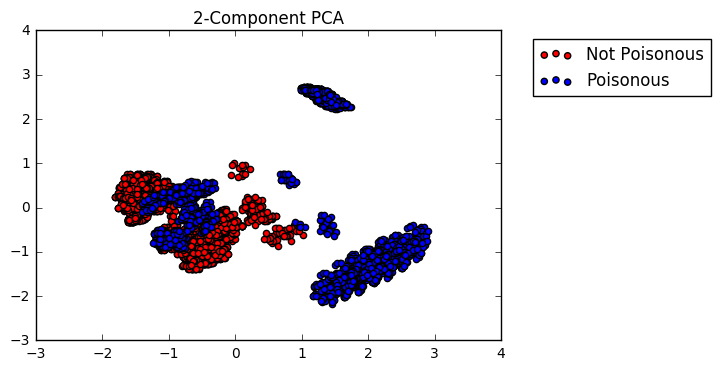

In [5]:
def P2():
    ### STUDENT START ###
    p2_pca=PCA(n_components=2)
    p2_2dim_pca = p2_pca.fit_transform(train_data)

    # Split 2d PCA data into poisonous and not-poisonous sets
    pca_pos_train = p2_2dim_pca[np.where(train_labels==1)]
    pca_neg_train = p2_2dim_pca[np.where(train_labels==0)]
    
    # Plot the data
    plt.scatter(pca_neg_train[:,0],pca_neg_train[:,1],c='r',label="Not Poisonous")
    plt.scatter(pca_pos_train[:,0],pca_pos_train[:,1],c='b',label="Poisonous")
    plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
    plt.title("2-Component PCA")
    ### STUDENT END ###
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

In [6]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

In [7]:
# Custom Function to calculate the distance of the points furthest from their cluster center
# Used in P3
def calc_Distances(data,clusters):
    dist = [None]*data.shape[0]
    for i in range(len(data)):
        lab = clusters.labels_[i]
        dist[i] = EuclideanDistance(data[i],clusters.cluster_centers_[lab])
    temp = []
    max_dists = []
    for i in range(clusters.n_clusters):
        temp = []
        for j in np.where(clusters.labels_==i)[0]:
            temp.append(dist[j])
        max_dists.append(max(temp))
    return(max_dists)

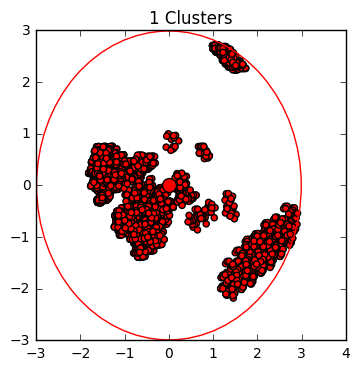

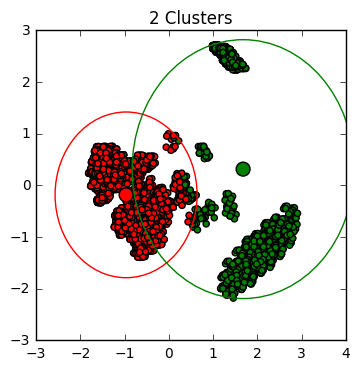

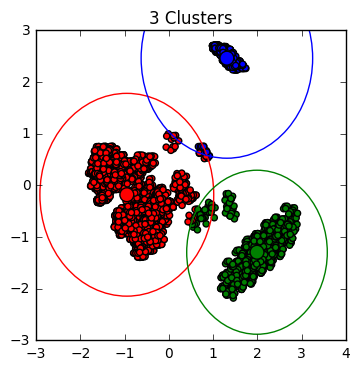

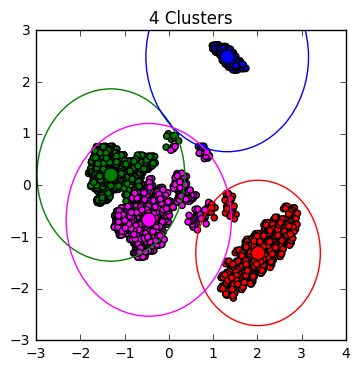

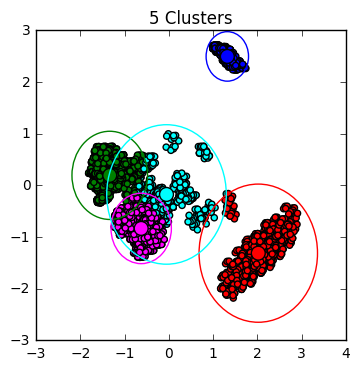

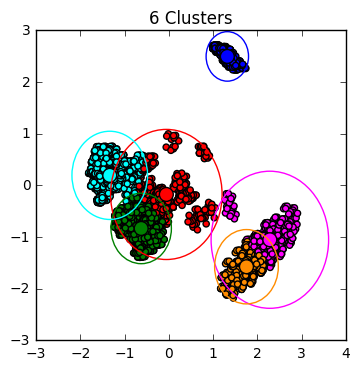

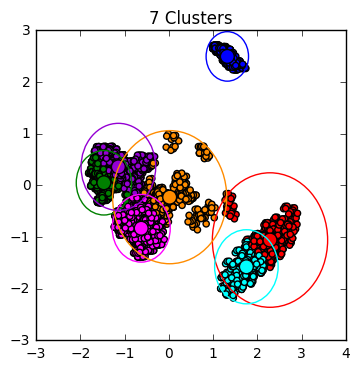

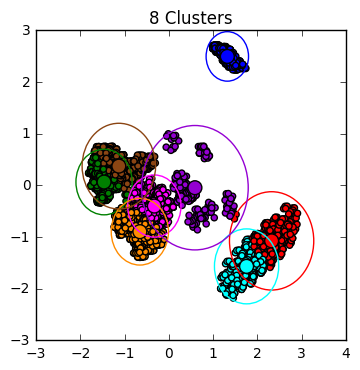

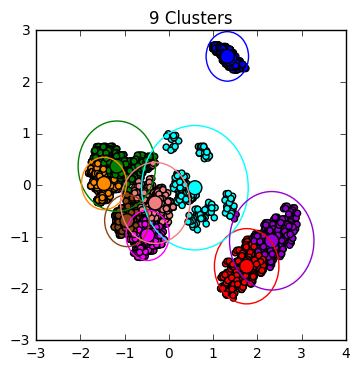

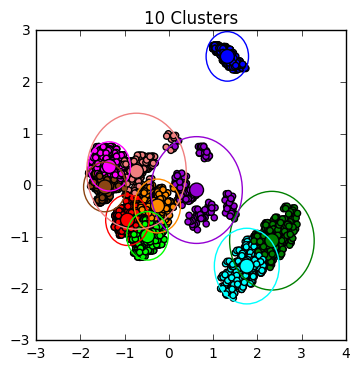

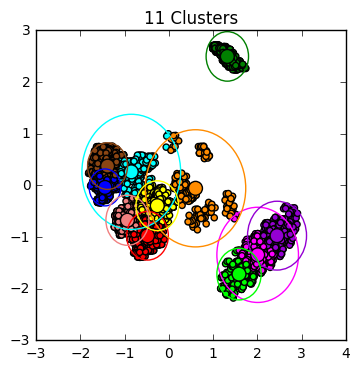

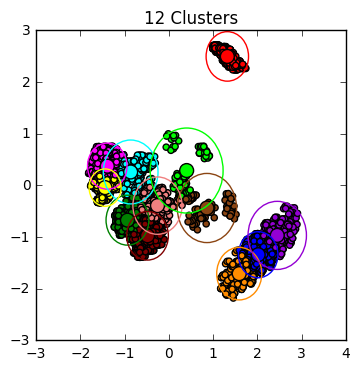

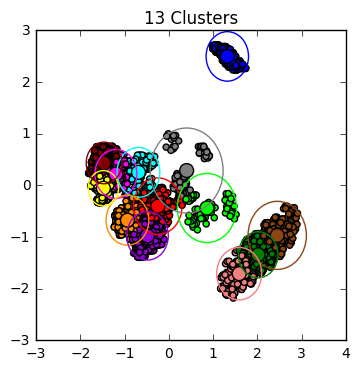

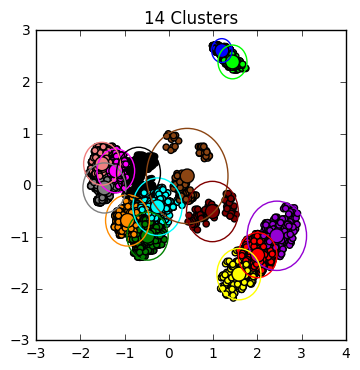

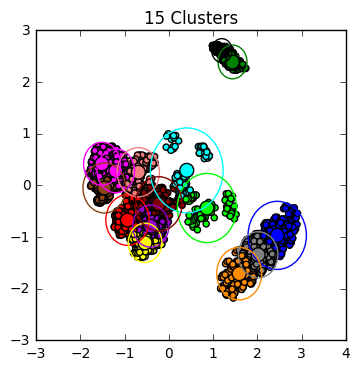

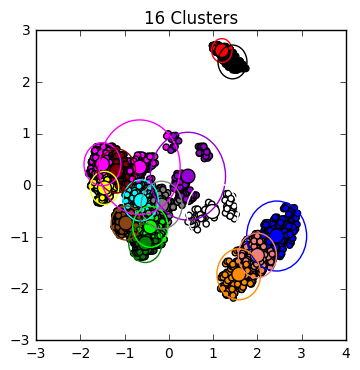

In [8]:
def P3(N):
    ### STUDENT START ###

    # Create data projected down to 2 dimensions
    p3_2d_pca=PCA(n_components=2).fit_transform(train_data)
    
    # Fit the 2d data with KMeans
    km = KMeans(n_clusters=N, init='k-means++')
    clust = km.fit(p3_2d_pca)
    
    # Define colors to use for plotted points
    myColors = ('red','green','blue','magenta','cyan','darkorange','darkviolet','saddlebrown','lightcoral',
                'lime','yellow','maroon','gray','black','fuchsia','white')
    myClCols = [None]*p3_2d_pca.shape[0]
    for ii in np.arange(0,len(clust.labels_)):
        color_index = clust.labels_[ii]
        myClCols[ii] = myColors[color_index]
    
    # Plot data
    plt.figure(figsize=(4,4))
    plt.scatter(p3_2d_pca[:,0], p3_2d_pca[:,1], c=myClCols)
    
    # Define cluster center color and plot it
    myCntrCol = [None]*N
    for ii in np.arange(0,N):
        color_index = ii
        myCntrCol[ii] = myColors[color_index]
    plt.scatter(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1], c=myCntrCol, s=100)
    
    # Use custom function (see above cell) to calculate the Euclidean Distances of each point from their cluster center, 
    # and then identify the furthest point. This distance will be used to define the radius of the cluster circle.
    distances = calc_Distances(p3_2d_pca, clust)
    
    # Plot the circles to pass through the furthest point from cluster center
    for jj in range(len(clust.cluster_centers_)):
        plt.gcf().gca().add_artist(plt.Circle((clust.cluster_centers_[jj,0],clust.cluster_centers_[jj,1]),
                                              distances[jj],color=myCntrCol[jj],fill=False))
    plt.title(str(N) + " Clusters")
    plt.show()
    return clust

    
### STUDENT END ###

#P3()

for nn in range(1,17):
    clust = P3(nn)


(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

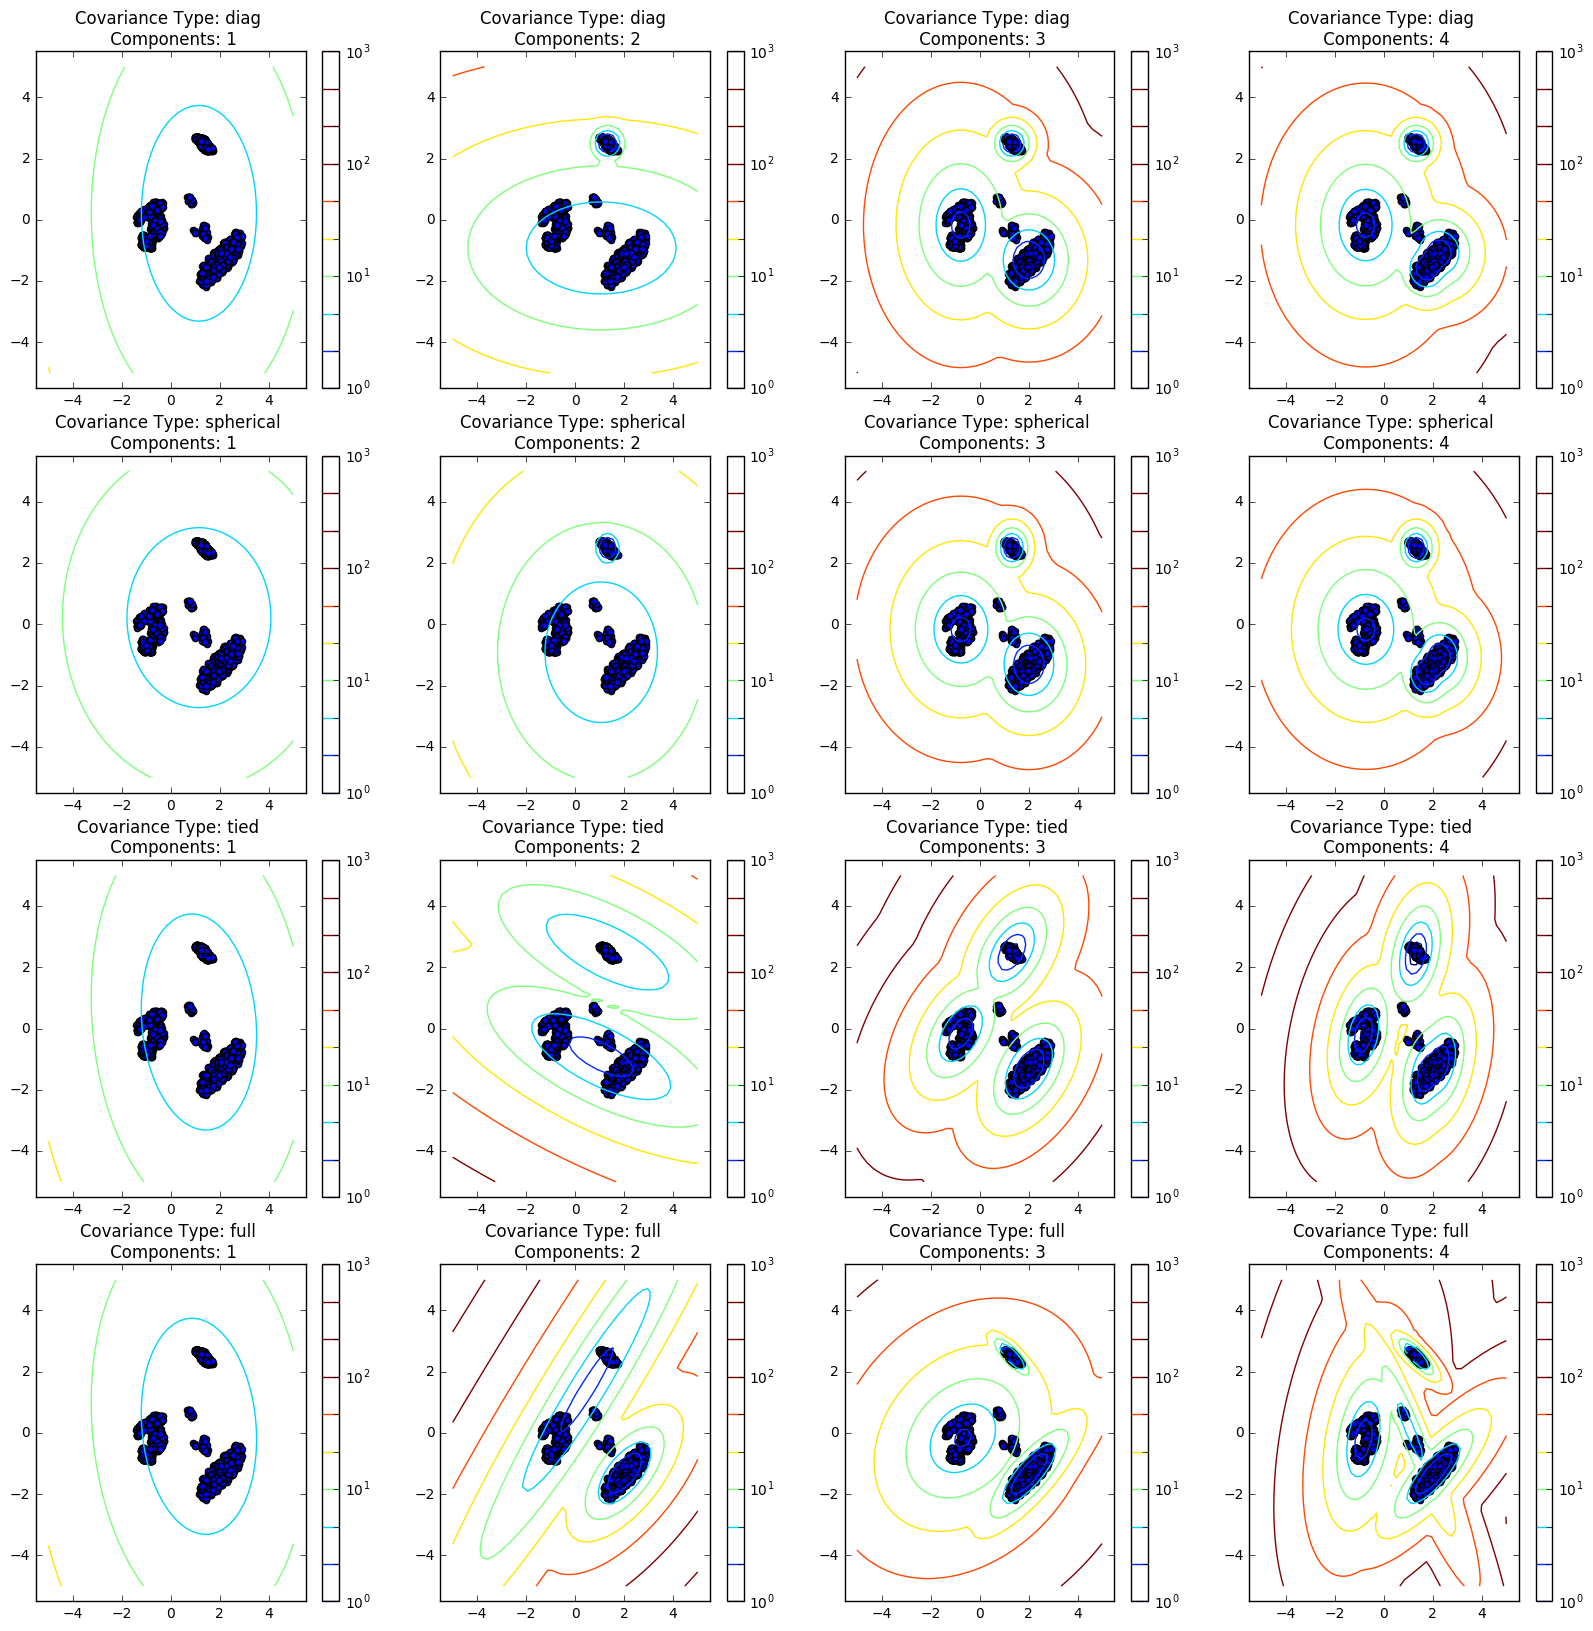

In [127]:
def P4():
    
    ### STUDENT START ###
    # create counter for plots
    counter = 0
    
    # Project training data down to 2 dimensions
    p4_pca=PCA(n_components=2)
    p4_2d_pca = p4_pca.fit_transform(train_data)

    # Pull out only the poisionous mushrooms
    pca_pos_train = p4_2d_pca[np.where(train_labels==1)]

    # Define figure size for plots
    plt.figure(figsize=(20, 20))
    
    # list of covariance types to iterate through below
    cov_types = ['diag','spherical','tied','full']
    
    # Iterate through covariance types 
    for i in range(len(cov_types)):

        # Iterate through the 4 mixture component values
        for j in range(1,5):
            
            counter = counter+1
            ax = plt.subplot(4, 4, counter)
            
            #Perform GMM using the looping values defined above
            p4_gmm = GaussianMixture(n_components=j, covariance_type=cov_types[i])
            p4_gmm.fit(pca_pos_train)

            # Generate the plot characteristics including the GMM density contours
            x = np.linspace(-5., 5.)
            y = np.linspace(-5., 5.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -p4_gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=1, extend='both')
            plt.scatter(pca_pos_train[:, 0], pca_pos_train[:, 1])
            plt.title("Covariance Type: %s \n Components: %d" % (cov_types[i], j))
    plt.show()
     ### STUDENT END ###
        
P4()

In [153]:
x_pca=PCA(n_components=3)
x_3d_pca = x_pca.fit_transform(train_data)


x_gmm = GaussianMixture(n_components=4, covariance_type='tied')
x_gmm.fit(x_3d_pca)

x_gmm.covariances_

array([[ 0.16460795, -0.0207179 ,  0.03022247],
       [-0.0207179 ,  0.15282692, -0.10727588],
       [ 0.03022247, -0.10727588,  0.30699189]])

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [9]:
def P5(pca_dim, gmm_comp, cov_type):
    ### STUDENT START ###

    # Project train data to N dimensions
    p5_pca=PCA(n_components=pca_dim)
    p5_2d_train = p5_pca.fit_transform(train_data)

    # using the fitted model for train data, transform the test data in accordance
    p5_2d_test = p5_pca.transform(test_data)

    # Split the trained 2d data into poisonous and non-poisonous sets
    p5_pos_dta = p5_2d_train[np.where(train_labels==1)]
    p5_neg_dta = p5_2d_train[np.where(train_labels==0)]

    # Fit a GMM model for the two (positive/negative) sets of 2d train data
    p5_pos_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(p5_pos_dta)
    p5_neg_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(p5_neg_dta)

    # compute the score for each record in the test set when applied to the 2 GMM models
    # we predict the test record to be classified according to whichever GMM model results in a higher score
    preds = [None]*len(p5_2d_test)
    for i in range(len(p5_2d_test)):
        x = p5_pos_gmm.score(p5_2d_test[i].reshape(1,-1))
        y = p5_neg_gmm.score(p5_2d_test[i].reshape(1,-1))
        if (x>y):
            preds[i]=1
        else:
            preds[i]=0

    # I built this to return predictions, so I can use this function in P6
    return(preds)

    ### STUDENT END ###
#P5(2,4,"full")
print "GMM Prediction Accuracy:", round(np.mean(P5(2,4,"full")==test_labels),5)*100,"%"

GMM Prediction Accuracy: 94.84 %


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [12]:
def param_check(cov_type, dim, comp):
    if cov_type=='diag':
        param = ((dim*2)*comp)*2
    elif cov_type=='spherical':
        param = ((dim+1)*comp)*2
    elif cov_type=='full':
        param = ((dim+((dim*(dim+1))/2))*comp)*2
    elif cov_type=='tied':
        param = ((dim*comp)+((dim*(dim+1))/2)*comp)*2    
    return(param)

In [14]:
def optimizeP5():
    
    #Create empty lists to populate as we go
    accuracies = []
    pca_dims = []
    gmm_comps = []
    cov_types = []
    cov=['full','spherical','diag','tied']

# In the ugly series of for loops below, I am iterating through all of the possible combinations of parameters
# and referencing back to a custom function above called "param_check" to calculate the number of parameters
# For each iteration that is below 50 parameters, I make a call back to P5 to calculate the prediction accuracy with 
# the respective variables.

# I know that there are prebuilt tools for finding optimal values similar to GridSearch, but I'm trying to stay strict to
# the packages provided in the assignment.

# j = PCA Dimensions
# k = GMM Components


    for i in range(len(cov)):
        for j in range(1,50):
            for k in range (1,50):
                if param_check(cov[i],j,k) < 50:
                    pca_dims.append(j)
                    gmm_comps.append(k)
                    cov_types.append(cov[i])
                    accuracies.append(np.mean(P5(j,k,cov[i])==test_labels))

    # After iterating through all possible combinations of parameters
    # I identify the index for the optimal accuracy, and then print out the respective details
    optimal_idx = np.where(accuracies==max(accuracies))[0][0]
    print "Parameters:",param_check(cov_types[optimal_idx], pca_dims[optimal_idx],gmm_comps[optimal_idx])
    print "PCA Dimensions:", pca_dims[optimal_idx]
    print "GMM Components:", gmm_comps[optimal_idx]
    print "Covariance Type:", cov_types[optimal_idx]
    print "Accuracy:", round(accuracies[optimal_idx],5)*100,"%"
    
optimizeP5()

Parameters: 48
PCA Dimensions: 7
GMM Components: 3
Covariance Type: spherical
Accuracy: 97.331 %
